### <strong>主題:
啤酒評論評分預測 - 分類模型訓練結果測試
### <strong>說明:
花了不少時間終於完成模型的訓練了，接下來就剩下最後一個重要的步驟 - 驗證模型了，這是一 <br />
個相當重要的部分，如何從訓練結果的驗證中評估模型的好壞，並進一步得知如何改善模型是實務 <br />
中必經的一個過程。

### <strong>題目
1. 建構出預測模型的框架，並且載入上次訓練完畢的模型
2. 以預測模型評估先前作業所分割出資料及的各項評分
3. 預測完成之後計算每出各項評分的準確度(accuracy)與解釋力(R square)

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
from transformers import DistilBertModel, DistilBertTokenizer
import sklearn.metrics as metrics

In [2]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-cased'# "bert-base-cased"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TOKENIZER = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 255

In [37]:
class BeerRateClassifier(nn.Module):
    """
    啤酒評論評分分類模型的主體
    Beer sentiment main model for review sentiment analyzer
    """
    def __init__(self,
                 apperance_n_classes,
                 aroma_n_classes,
                 overall_n_classes,
                 palate_n_classes,
                 taste_n_classes,
                ):
        super(BeerRateClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.apperance_out = nn.Sequential(
                                nn.Dropout(p=0.2),
                                nn.Linear(self.bert.config.hidden_size, apperance_n_classes)
                             )
        self.aroma_out = nn.Sequential(
                                nn.Dropout(p=0.2),
                                nn.Linear(self.bert.config.hidden_size, aroma_n_classes)     
                            )
        self.overall_out = nn.Sequential(
                                nn.Dropout(p=0.2),
                                nn.Linear(self.bert.config.hidden_size, overall_n_classes)
                            )
        self.palate_out = nn.Sequential(
                                nn.Dropout(p=0.2),
                                nn.Linear(self.bert.config.hidden_size, palate_n_classes)
                            )
        self.taste_out = nn.Sequential(
                                nn.Dropout(p=0.2),
                                nn.Linear(self.bert.config.hidden_size, taste_n_classes)
                            )
        
    def load_model(self, path):
        """
        載入先前訓練好的權重檔
        """
        self.load_state_dict(torch.load(path, map_location=DEVICE))

    def forward(self, input_ids, attention_mask):
        (output,) = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = output[:,-1,:].squeeze(dim=1)
        
        apperance_output = self.apperance_out(pooled_output)
        aroma_output = self.aroma_out(pooled_output)
        overall_output = self.overall_out(pooled_output)
        palate_output = self.palate_out(pooled_output)
        taste_output = self.taste_out(pooled_output)
        return {
            "apperance": apperance_output,
            "aroma": aroma_output,
            "overall": overall_output,
            "palate": palate_output,
            "taste": taste_output,
        }
    
    def predicts(self, text):
        """
        主要的分類器，將input電影評論輸入模型，將輸出轉化為預測評分
        make prediction according to the text with the given model
        """
        encoding = TOKENIZER.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        (output,) = self.bert(
            input_ids=encoding["input_ids"],
            attention_mask=encoding["attention_mask"]
        )
        pooled_output = output[:,-1,:].squeeze(dim=1)
#         print(output.size(), pooled_output.size())
        apperance_output = self.apperance_out(pooled_output)
        aroma_output = self.aroma_out(pooled_output)
        overall_output = self.overall_out(pooled_output)
        palate_output = self.palate_out(pooled_output)
        taste_output = self.taste_out(pooled_output)
        
        _, apperance_preds = torch.max(apperance_output, dim=1)
        _, aroma_preds = torch.max(aroma_output, dim=1)
        _, overall_preds = torch.max(overall_output, dim=1)
        _, palate_preds = torch.max(palate_output, dim=1)
        _, taste_preds = torch.max(taste_output, dim=1)
        
        return {"apperance_preds": int(apperance_preds),
                "aroma_preds": int(aroma_preds),
                "overall_preds": int(overall_preds),
                "palate_preds": int(palate_preds),
                "taste_preds": int(taste_preds)
               }

In [38]:
VAL = pd.read_json("test_set.json")
VAL = VAL.dropna(subset=['review/text']).sample(frac=1).reset_index(drop=True)
TEST = list(VAL['review/text'])[:200] + list(VAL['review/text'])[-200:]
TRUE_review_appearance = list(VAL.review_appearance)[:200] + list(VAL.review_appearance)[-200:]
TRUE_review_aroma = list(VAL.review_aroma)[:200] + list(VAL.review_aroma)[-200:]
TRUE_review_overall = list(VAL.review_overall)[:200] + list(VAL.review_overall)[-200:]
TRUE_review_palate = list(VAL.review_palate)[:200] + list(VAL.review_palate)[-200:]
TRUE_review_taste = list(VAL.review_taste)[:200] + list(VAL.review_taste)[-200:]

In [39]:
""" 分類模型 """
MODEL = BeerRateClassifier(4, 4, 4, 4, 4)
MODEL.load_model("pytorch_model.bin")

In [40]:
predict = MODEL.predicts(TEST[1])
print(predict)

{'apperance_preds': 2, 'aroma_preds': 2, 'overall_preds': 2, 'palate_preds': 2, 'taste_preds': 2}


In [41]:
data = []
for test in tqdm(TEST):
    predict = MODEL.predicts(test)
    data.append(predict)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.80it/s]


In [42]:
apperance_preds = []
aroma_preds = []
overall_preds = [] 
palate_preds = []
taste_preds = []
for predict in data:
    apperance_preds.append(predict['apperance_preds'])
    aroma_preds.append(predict['aroma_preds'])
    overall_preds.append(predict['overall_preds']) 
    palate_preds.append(predict['palate_preds'])
    taste_preds.append(predict['taste_preds'])

In [43]:
TRUE_review_appearance = list(VAL.review_appearance)[:200] + list(VAL.review_appearance)[-200:]
TRUE_review_aroma = list(VAL.review_aroma)[:200] + list(VAL.review_aroma)[-200:]
TRUE_review_overall = list(VAL.review_overall)[:200] + list(VAL.review_overall)[-200:]
TRUE_review_palate = list(VAL.review_palate)[:200] + list(VAL.review_palate)[-200:]
TRUE_review_taste = list(VAL.review_taste)[:200] + list(VAL.review_taste)[-200:]

for (TRUE, data, desc) in zip([TRUE_review_appearance, TRUE_review_aroma, TRUE_review_overall, TRUE_review_palate, TRUE_review_taste],
                  [apperance_preds, aroma_preds, overall_preds, palate_preds, taste_preds],
                  ['apperance', 'aroma', 'overall', 'palate', 'taste']):
    print(desc, metrics.accuracy_score(TRUE, data))
    print(desc, metrics.r2_score(TRUE, data))
    print('='*30)

apperance 0.1375
apperance 0.0
aroma 0.225
aroma 0.0
overall 0.415
overall 0.0
palate 0.41
palate 0.0
taste 0.365
taste 0.0


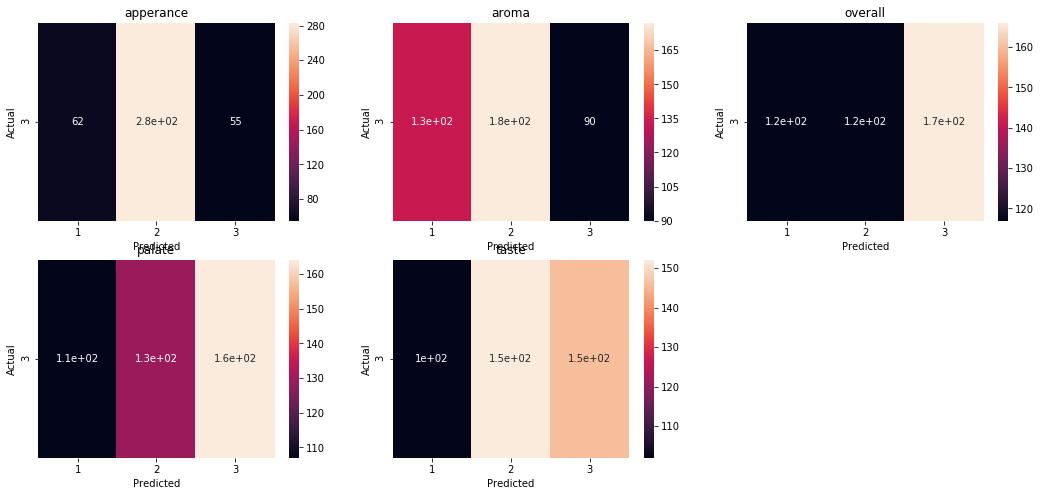

In [44]:
plt.figure(figsize=(18,8))
for i, (TRUE, data, desc) in enumerate(zip([TRUE_review_appearance, TRUE_review_aroma, TRUE_review_overall, TRUE_review_palate, TRUE_review_taste],
                         [apperance_preds, aroma_preds, overall_preds, palate_preds, taste_preds],
                         ['apperance', 'aroma', 'overall', 'palate', 'taste']), 1):
    plt.subplot(2,3,i)
    RESULT = pd.DataFrame({"True": TRUE, "Predict": data})
    confusion_matrix = pd.crosstab(RESULT["True"], RESULT["Predict"], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)
    plt.title(desc)